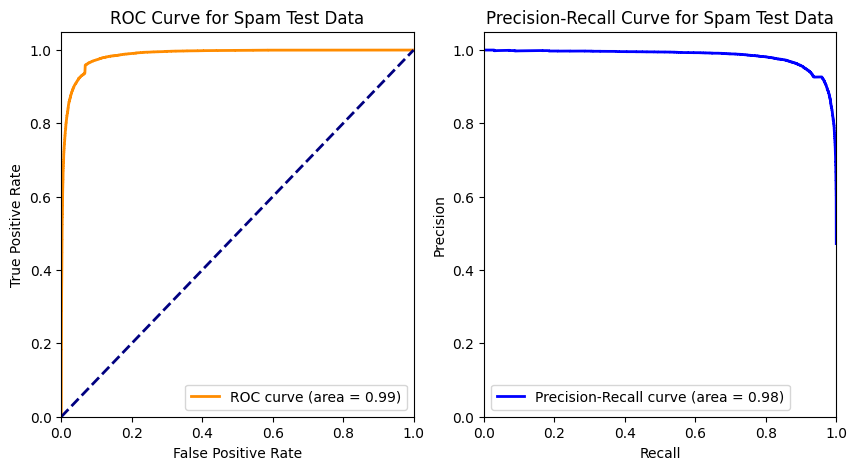

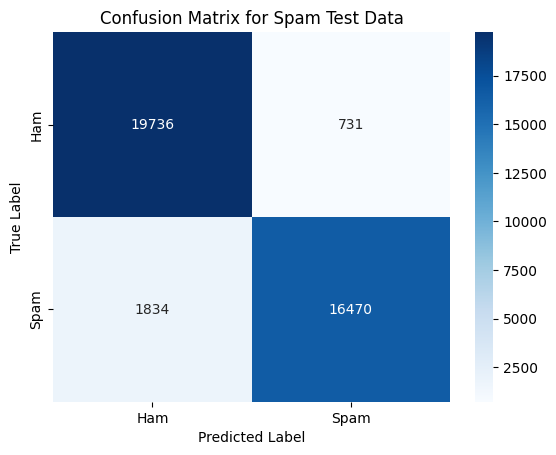


Spam Test Data Accuracy: 0.9338423048154548
Spam Test Data Classification Report:
               precision    recall  f1-score   support

         Ham       0.91      0.96      0.94     20467
        Spam       0.96      0.90      0.93     18304

    accuracy                           0.93     38771
   macro avg       0.94      0.93      0.93     38771
weighted avg       0.94      0.93      0.93     38771



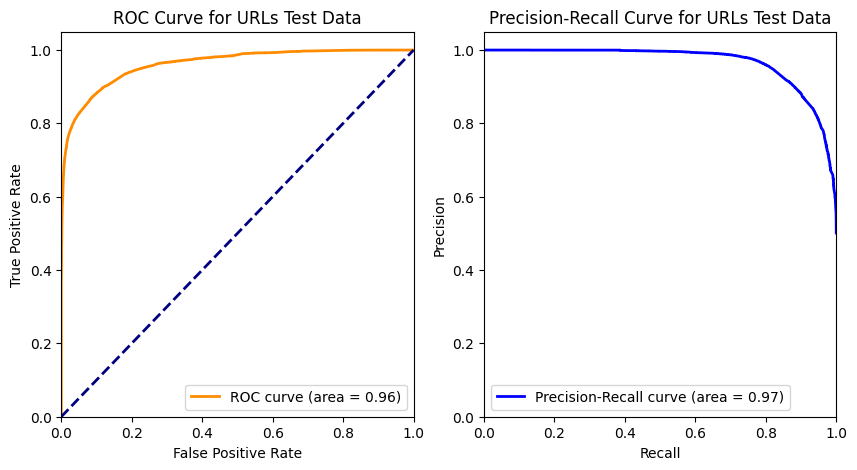

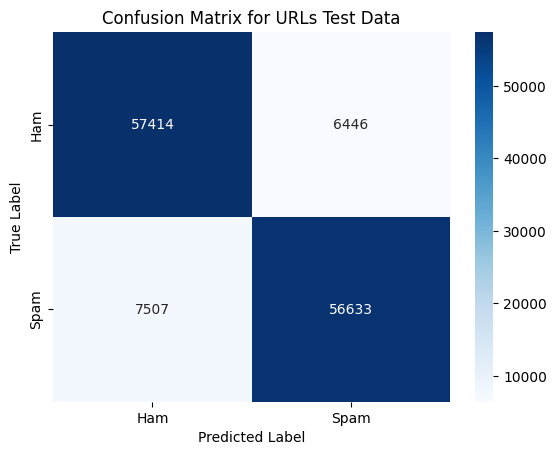


URLs Test Data Accuracy: 0.8909921875
URLs Test Data Classification Report:
               precision    recall  f1-score   support

         Ham       0.88      0.90      0.89     63860
        Spam       0.90      0.88      0.89     64140

    accuracy                           0.89    128000
   macro avg       0.89      0.89      0.89    128000
weighted avg       0.89      0.89      0.89    128000



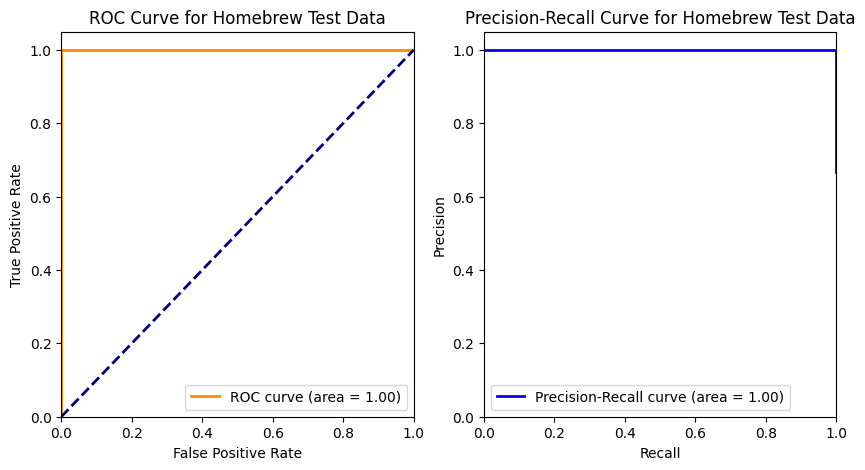

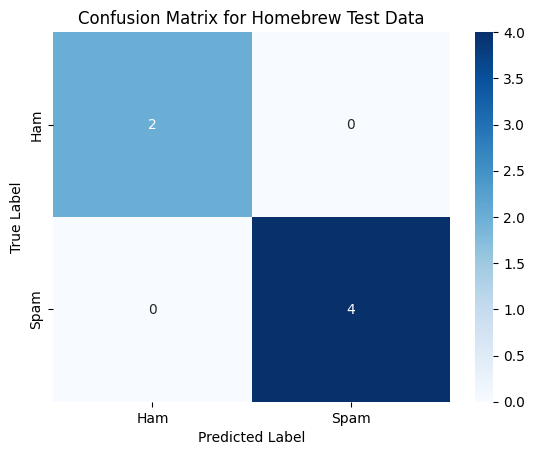


Homebrew Test Data Accuracy: 1.0
Homebrew Test Data Classification Report:
               precision    recall  f1-score   support

         Ham       1.00      1.00      1.00         2
        Spam       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Load datasets
spam_full = pd.read_csv('spam_Emails_data.csv').fillna('')
spam_full['label'] = spam_full['label']

urls_full = pd.read_csv('data/phishing_urls_train.csv').fillna('')
urls_full['label'] = urls_full['label'].apply(lambda x: 'Spam' if x == 1 else 'Ham')

homebrew_data = pd.read_csv('HomebrewDataset.csv').fillna('')
homebrew_data['label'] = homebrew_data['label']

# Split each dataset into training and testing sets
spam_train, spam_test = train_test_split(spam_full, test_size=0.2, random_state=42)
urls_train, urls_test = train_test_split(urls_full, test_size=0.2, random_state=42)
homebrew_train, homebrew_test = train_test_split(homebrew_data, test_size=0.2, random_state=42)

# Combine the training data from all datasets
combined_train = pd.concat([spam_train, urls_train], ignore_index=True)

# Feature extraction for combined training data
X_train = tfidf_vectorizer.fit_transform(combined_train['text'])
y_train = combined_train['label']

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

def evaluate_model(X, y, model, dataset_name):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    fpr, tpr, _ = roc_curve(y.map({'Ham': 0, 'Spam': 1}), model.predict_proba(X)[:, 1])
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y.map({'Ham': 0, 'Spam': 1}), model.predict_proba(X)[:, 1])
    pr_auc = auc(recall, precision)
    conf_matrix = confusion_matrix(y, predictions)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {dataset_name}')
    plt.legend(loc="lower left")
    plt.show()

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\n{dataset_name} Accuracy:", accuracy)
    print(f"{dataset_name} Classification Report:\n", classification_report(y, predictions))

# Evaluate the models
X_spam_test = tfidf_vectorizer.transform(spam_test['text'])
y_spam_test = spam_test['label']
evaluate_model(X_spam_test, y_spam_test, model, "Spam Test Data")

X_urls_test = tfidf_vectorizer.transform(urls_test['text'])
y_urls_test = urls_test['label']
evaluate_model(X_urls_test, y_urls_test, model, "URLs Test Data")

X_homebrew_test = tfidf_vectorizer.transform(homebrew_test['text'])
y_homebrew_test = homebrew_test['label']
evaluate_model(X_homebrew_test, y_homebrew_test, model, "Homebrew Test Data")
